In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pandas as pd
from tqdm import tqdm
import joblib
from typing import Tuple, Optional, Union


# ベルヌーイ試行(Cramer条件非成立)

In [2]:
mean_true = 0.3
alpha = 0.95

def distr_wrapper(
    mean: float, rng: np.random.Generator, size: Union[int, tuple[int]]
) -> np.ndarray:
    return rng.binomial(n=1, p=mean, size=size)


In [3]:
def calc_conf_interval_normal(x: np.ndarray, alpha: float = 0.05) -> float:
    n = len(x)
    x_mean = np.mean(x)
    x_std = np.std(x, ddof=1)
    z_alpha = stats.norm.ppf(1 - alpha)
    ci = z_alpha * x_std / np.sqrt(n)
    return x_mean - ci


In [4]:
def calc_conf_interval_bs(
    rng: np.random.Generator, x: np.ndarray, alpha: float = 0.05, mc: int = 1000
) -> float:
    n = len(x)
    x_mean = np.mean(x)
    bs_samples = distr_wrapper(x_mean, rng, size=(mc, n))
    bs_means = np.mean(bs_samples, axis=1)
    bs_stds = np.std(bs_samples, axis=1, ddof=1)
    studentized_samples = np.sqrt(n) * (bs_means - x_mean) / bs_stds  # 分布がなめらかでないとき、分散の推定値が0になることがある
    studentized_samples = studentized_samples[~np.isnan(studentized_samples)]  # 欠損を削除
    upper = np.quantile(studentized_samples, 1 - alpha)
    return x_mean - upper * np.std(x, ddof=1) / np.sqrt(n)  # これ合ってる?


In [5]:
# 信頼区間を計算して、真の平均が信頼区間に入っている確率が0.95 になるか確認する
# normal version

SEED = 42
DEBUG = False
# n_list = [100, 500, 1000]
n_list = [20]

if DEBUG:
    MC = 1000
else:
    MC = 50000

mc_bs = 1000  # bootstrapのサンプル数

prob_seq_list_normal = []
for n in n_list:
    ss = np.random.SeedSequence(SEED)
    child_seeds = ss.spawn(MC)
    streams = [np.random.default_rng(s) for s in child_seeds]

    def main(rng):
        x = distr_wrapper(mean_true, rng, size=n)
        upper = calc_conf_interval_normal(x, alpha)  # change here
        return int(mean_true <= upper)

    res = joblib.Parallel(n_jobs=8, verbose=2)(
        joblib.delayed(main)(rng) for rng in streams
    )
    res = np.array(res)
    prob_seq = np.cumsum(res) / np.array(range(1, MC + 1))
    prob_seq_list_normal.append(prob_seq)

# bootstrap version
prob_seq_list_bs = []
for n in n_list:
    ss = np.random.SeedSequence(SEED)
    child_seeds = ss.spawn(MC)
    streams = [np.random.default_rng(s) for s in child_seeds]

    def main(rng):
        x = distr_wrapper(mean_true, rng, size=n)
        upper = calc_conf_interval_bs(rng, x, alpha, mc=mc_bs)  # change here
        return int(mean_true <= upper)

    res = joblib.Parallel(n_jobs=8, verbose=2)(
        joblib.delayed(main)(rng) for rng in streams
    )
    res = np.array(res)
    prob_seq = np.cumsum(res) / np.array(range(1, MC + 1))
    prob_seq_list_bs.append(prob_seq)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 4608 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 50000 out of 50000 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
/var/folders/w6/n9ym2dfj19g5smxn2xlw8m980000gn/T/ipykernel_86012/4023374589.py:9: RuntimeWarning: divide by zero encountered in divide
/var/folders/w6/n9ym2dfj19g5smxn2xlw8m980000gn/T/ipykernel_86012/4023374589.py:9: RuntimeWarning: divide by zero encountered in divide
/var/folders/w6/n9ym2dfj19g5smxn2xlw8m980000gn/T/ipykernel_86012/4023374589.py:9: RuntimeWarning: divide by zero encountered in divide
/var/folders/w6/n9ym2dfj19g5smxn2xlw8m980000gn/T/ipykernel_86012/4023374589.py:9: RuntimeWarning: divide by zero encountered in divide
/var/folders/w6/n9ym2dfj19g5smxn2xlw8m980000gn/T/ipykernel_86012/4023374589.py:9: RuntimeWarning: divide by zero 

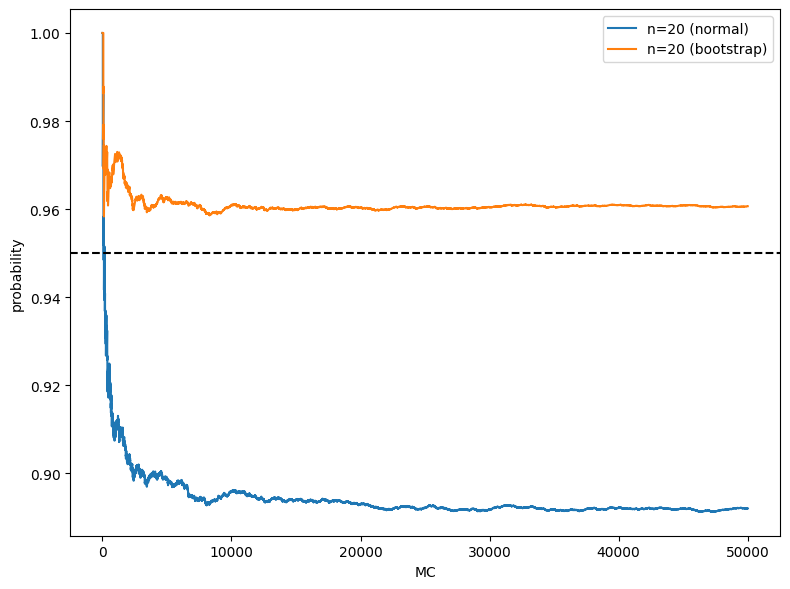

In [6]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for n, prob_seq in zip(n_list, prob_seq_list_normal):
    sns.lineplot(prob_seq, label=f"n={n} (normal)", ax=ax)
for n, prob_seq in zip(n_list, prob_seq_list_bs):
    sns.lineplot(prob_seq, label=f"n={n} (bootstrap)", ax=ax)
ax.legend()
ax.set_xlabel("MC")
ax.set_ylabel("probability")
# ax.set_ylim(alpha-0.20, alpha+0.05)
ax.axhline(alpha, color="k", linestyle="--")
fig.tight_layout()
